<p dir=rtl style="direction: rtl;text-align: center;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=5>
    <b>پروژه دوم درس مباحثی در علوم کامیوتر: پیاده سازی MLP </b><br>
    گروه 16: مهدی غیاثی، سینا ارزبین، نیما ابراهیمی
</font>    
</p>


In [51]:
class Tensor:

  def __init__(self, value, label='', children=(), operator=None):
    self.value = value
    self.children = set(children)
    self.operator = operator
    self.grad = 0
    self._backward = lambda  : None
    self.label = label

  def __repr__(self) -> str:
    return f"Tensor(value={self.value})"

  def __mul__(self, other):
    other = other if isinstance(other, Tensor) else Tensor(other)

    out = Tensor(self.value*other.value, children= (self, other), operator='*')

    def backward():
      self.grad = other.value * out.grad
      other.grad = self.value * out.grad

    out._backward = backward

    return out

  def __add__(self, other):

    other = other if isinstance(other, Tensor) else Tensor(other)

    out = Tensor(self.value+other.value, children= (self, other), operator='+')

    def backward():
      self.grad += 1 * out.grad
      other.grad += 1 * out.grad

    out._backward = backward

    return out
  
  def __sub__(self, other):
    other = other if isinstance(other, Tensor) else Tensor(other)

    out = Tensor(self.value-other.value, children= (self, other), operator='-')

    def backward():
      self.grad += 1 * out.grad
      other.grad += -1 * out.grad

    out._backward = backward

    return out

  def __radd__(self, other):
    return self + other

  def __rsub__(self, other):
    return -1 * self + other
  
  def __rmul__(self, other):
    return self * other

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>کلاس Tensor: </b><br>
     هر تنسور یک شی دارای مقدار، فرزند و ابزار های لازم برای محاسبه عبارات ریاضی و همچنین مشتق نسبت به فرزندان می‌باشد. این کلاس دارای متد‌هایی برای انجام عملیات مختلف روی تنسور است که شامل جمع، تفریق و ضرب است. در هر کدام از این متد‌ها عملیات مورد نظر انجام می‌شود و خروجی به صورت یک تنسور جدید باز گردانده می‌شود. همچنین در این متدها یک تابع به نام backward نیز وجود دارد که گرادیان تنسور های فرزند را نسبت تنسور مورد نظر محاسبه می‌کند.
</font>    
</p>


In [52]:
import math

class F:
    @staticmethod
    def tanh(x:Tensor):
        val = x.value
        out = Tensor(value=(math.exp(val)-math.exp(-1*val))/(math.exp(val)+math.exp(-1*val)), children=(x,), operator='tanh')
        
        def backward():
            x.grad = (1 - out.value**2) * out.grad
        
        out._backward = backward

        return out


    @staticmethod
    def calc_loss(y_hat:Tensor, y):
        out = Tensor(value=(y_hat.value - y)*(y_hat.value - y), label='loss', children=(y_hat,), operator='loss')

        out.grad = 1

        def backward():
            y_hat.grad = 2 * (y_hat.value - y)
        
        out._backward = backward

        return out
    

    @staticmethod
    def topological_sort(tensor:Tensor, visited, list):
        visited.append(tensor)

        for child in tensor.children:
            if child not in visited:
                F.topological_sort(child, visited, list)
        
        list.append(tensor)
        return list[::-1]
    

    @staticmethod
    def backward_button(loss:Tensor):
        list = F.topological_sort(loss, [], [])
        for tensor in list:
            tensor._backward()

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>کلاس F: </b><br>
    این کلاس شامل متدهای کاربردی است که در ادامه به آن‌ها نیاز داریم.<br>
    متد tanh: این متد تابع فعال ساز ما می‌باشد و مقدار تابع تانژانت هایپربولیک را برای یک تنسور ورودی محاسبه می‌کند و خروجی را به صورت یک تنسور جدید باز می‌گرداند. همچنین گرادیان فرزند تنسور مورد نظر را نسب به تنسور خروجی محاسبه می‌کند.<br>
    <b>متد calc_loss:</b><br>
    این متد نیز با گرفتن تنسور مقدار پیش‌بینی شده و مقدار حقیقی، مقدار تابع خطا را برای آن‌ها محاسبه می‌کند و خروجی را به صورت یک تنسور جدید باز می‌گرداند. همچنین گرادیان فرزند تنسور مقدار پیش‌بینی شده را نسبت به تنسور خروجی با توجه به فرمول تابع زیان محاسبه می‌کند.<br>
    <b>متد topological_sort:</b><br>
    این متد تنسور loss را به عنوان ورودی گرفته و ترتیب صحیح برای محاسبه گرادیان ها را بر اساس ترتیب توپولوژیکی محاسبه می‌کند. این متد یک در نهایت نیز لیست تنسور ها را با ترتیب مشخص شده باز می‌گرداند.<br>
    <b>متد backward_button:</b><br>
    این متد از ترتیب توپولوژیکی که در متد topological_sort محاسبه شده استفاده می‌کند و گرادیان های تنسور ها به ترتیب را محاسبه می‌کند.
</font>    
</p>


In [53]:
import random 
class Neuron:

  def __init__(self, input_size):
    self.weights = [Tensor(random.random()) for i in range(input_size)]
    self.bias = Tensor(random.random())

  def forward(self, x):
    res = sum([w_i * x_i for w_i, x_i in zip(self.weights, x)])
    return F.tanh(res + self.bias)

  def __call__(self, x):
    return self.forward(x)

  def parameters(self):
    return self.weights + [self.bias]

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>کلاس Neuron: </b><br>
    این کلاس شامل متدهایی است که برای ساختن یک نورون نیاز داریم. هنگام ساخت نورون به تعداد نورون‌های ورودی به نورون مورد نظر وزن تصادفی به همراه یک بایاس تصادفی برای نورون در نظر گرفته می‌شود.<br>
    <b>متد forward:</b><br>
    این متد با گرفتن مقدار ورودی x، با توجه به وزن‌ها و بایاس مقدار خروجی را محاسبه می‌کند و سپس تابع فعال ساز را نیز بر روی آن اعمال کند. همچنین بخش مرتبط با این نورون در گراف محاسباتی نیز تشکیل داده می‌شود.

</font>    
</p>


In [54]:
class Layer:

  def __init__(self, input_size, output_size):
    self.neurons = [Neuron(input_size) for _ in range(output_size)]

  def forward(self, x):
    out = [neuron(x) for neuron in self.neurons]
    return out[0] if len(out)==1 else out

  def __call__(self, x):
    return self.forward(x)
  
  def parameters(self):
    return [parameter for neurons in self.neurons for parameter in neurons.parameters()]

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>کلاس Layer: </b><br>
    این کلاس شامل متدهایی است که برای ساختن یک لایه از نورون‌ها نیاز داریم. هنگام ساخت یک لایه به تعداد مورد نظر درون لایه نورون ساخته می‌شود.<br>
    <b>متد forward:</b><br>
    این متد با دریافت مقدار ورودی x، مقدار خروجی را برای هر یک از نورون های درون خود محاسبه می‌کند و باز می‌گرداند.
</font>    
</p>


In [55]:
class MLP:

  def __init__(self, input_size, layer_sizes):
    layers_total = [input_size] + layer_sizes
    self.layers = [Layer(layers_total[i], layers_total[i+1]) for i in range(len(layer_sizes))]

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def __call__(self, x):
    return self.forward(x)

  def parameters(self):
    return [parameter for layer in self.layers for parameter in layer.parameters()]
  

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>کلاس MLP: </b><br>
    این کلاس شامل متدهایی است که برای ساختن یک شبکه عصبی چند لایه‌ای نیاز داریم. هنگام ساخت یک شبکه عصبی به تعداد لایه‌های مورد نظر در شبکه لایه‌های مورد نظر ساخته می‌شود.<br>
    <b>متد forward:</b><br>
    این متد با گرفتن مقدار ورودی x، مقدار خروجی را برای هر یک از لایه‌های درون شبکه محاسبه می‌کند و باز می‌گرداند.<br>
    <b>متد parameters:</b><br>
    این متد لیست وزن‌ها و بایاس‌های تمامی نورون‌ها در شبکه را باز می‌گرداند.
    همچنین این متد درون کلاس های Neuron و Layer نیز تعریف شده بود.
</font>    
</p>


In [56]:
class Optimizer:
    def __init__(self, parameters, lr):
        self.parameters = parameters
        self.lr = lr
    
    def zero_grad(self):
        for parameters in self.parameters:
            parameters.grad = 0
        
    def step(self, grads):
        i = 0
        for parameter in self.parameters:
            parameter.value -= self.lr * grads[i]
            i+=1

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    <b>کلاس Optimizer:</b> <br>  
    این کلاس شامل متدهایی است که برای بهینه سازی وزن‌ها و بایاس‌های شبکه عصبی نیاز داریم. هنگام ساخت یک شی از این کلاس باید لیست پارامترهای شبکه‌ای که قصد بهینه سازی بر روی آن را داریم به همراه مقدار لرنینگ ریت دریافت کند.<br>
    <b>متد zero_grad:</b><br>
    این متد تمامی گرادیان‌های پارامترهای شبکه را صفر می‌کند. دلیل این کار این است که در بعضی حالت یک تنسور دارای دو یا چند والد می‌باشد و برای محاسبه گرادیان تنسور مورد نظر باید گرادیان تنسور را نسبت به هر والد حساب کرده و مجموع آن را به عنوان گرادیان نهایی تنسور اعلام کنیم. در این نوع پیاده سازی نیاز داریم پس از یک دور backward، مقدار گرادیان همه پارامتر ها صفر شود.<br>
    <b>متد step:</b><br>
    این متد با گرفتن یک لیست از گرادیان‌ها، وزن‌ها و بایاس‌ها را با توجه به گرادیان‌ها به روز رسانی می‌کند.
</font>    
</p>


<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    در ادامه شبکه عصبی بر روی سه مجموعه داده مختلف تست شده است. توضیحات فقط برای مجموعه داده اول نوشته شده است و برای دیگر مجموعه داده‌ها نیز مشابه است.<br>
</font>    
</p>


In [57]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt

X, Y = make_blobs(n_samples=100, n_features=2, centers=3, random_state=23)
Y = Y - 1

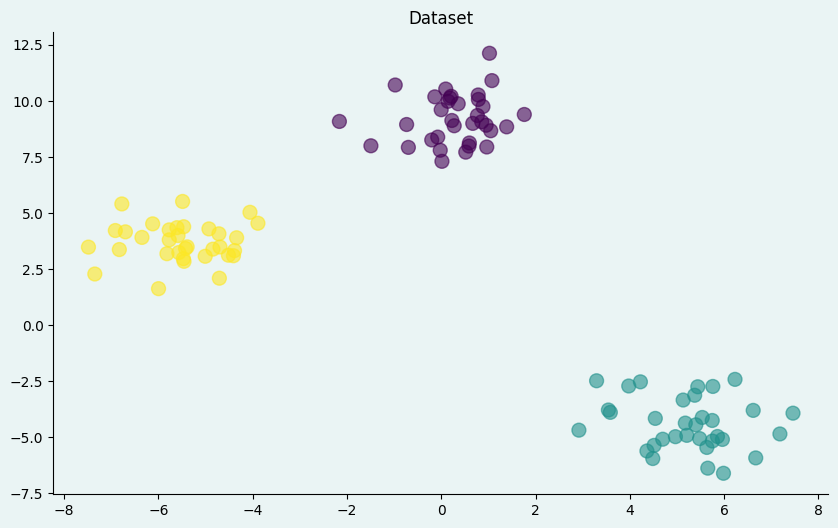

In [58]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(X[:,0], X[:,1], c=Y, cmap="viridis", alpha=0.6, s=100)

ax.set_title("Dataset")
ax.set_facecolor("#EAF4f4")
fig.set_facecolor("#EAF4f4")
ax.spines[["top", "right"]].set_visible(False)
plt.show()

In [60]:
model = MLP(2, [2, 1])
optim = Optimizer(model.parameters(), 0.01)

In [61]:
n_epochs = 200
costs = []
for epoch in range(n_epochs):
    y_hats = [model(x) for x in X]
    
    losses = [F.calc_loss(y_hat, y) for y_hat, y in zip(y_hats, Y)]
    cost = 0
    
    grads = []
    for param in model.parameters():
        grads.append(0)

    for loss in losses:
        cost += loss.value
        optim.zero_grad()
        F.backward_button(loss)
        
        i = 0
        for param in model.parameters():
            grads[i] += param.grad
            i += 1

    for grad in grads:
        grad /= len(Y)

    optim.step(grads)
   
    print(f'epoch{epoch+1} : cost:', cost/len(Y))
    costs.append(math.log10(cost))

epoch1 : cost: 1.8361878946311585
epoch2 : cost: 1.2717121483397462
epoch3 : cost: 0.8327641616937994
epoch4 : cost: 1.0387026492242974
epoch5 : cost: 0.9778824310935446
epoch6 : cost: 1.1701958031294823
epoch7 : cost: 0.6963422797123378
epoch8 : cost: 0.45350043153322595
epoch9 : cost: 0.7683797097116816
epoch10 : cost: 0.3759197209971474
epoch11 : cost: 0.118581375047796
epoch12 : cost: 0.035269347867219504
epoch13 : cost: 0.026212482598129774
epoch14 : cost: 0.02150193401788618
epoch15 : cost: 0.01839050737140134
epoch16 : cost: 0.016073228924831907
epoch17 : cost: 0.014330907093377277
epoch18 : cost: 0.012906559925318528
epoch19 : cost: 0.01177506855342534
epoch20 : cost: 0.010800501029514232
epoch21 : cost: 0.010000509181209895
epoch22 : cost: 0.009287480256471402
epoch23 : cost: 0.008688644697356864
epoch24 : cost: 0.008142097623861417
epoch25 : cost: 0.007675053510996895
epoch26 : cost: 0.007241545417268468
epoch27 : cost: 0.006865914375823869
epoch28 : cost: 0.00651299442824099

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    در این بخش فرایند یادگیری مدل پیاده سازی شده است. ابتدا یک شبکه عصبی چند لایه‌ای با تعداد لایه‌ها و تعداد نورون‌های خواسته شده ساخته می‌شود. همچنین یک بهینه ساز نیز ساخته می‌شود تا برای بهینه سازی شبکه عصبی از آن استفاده کنیم. در این فرایند ابتدا مقدار خروجی شبکه برای تمام داده‌های ورودی محاسبه می‌شود. سپس مقدار تابع خطا برای  مقادیر خروجی محاسبه می‌شود. در ادامه لیست grad ساخته می‌شود تا مجموع گرادیان های هر کدام از پارامتر ها را در آن ذخیره کنیم. با یک حلقه for بر روی مقادیر loss، به ازای هر مقدار loss متد backward_button فراخوانی می‌شود تا مقدار گرادیان ها درون هر تنسور بر حسب مقدار loss مورد نظر محاسبه شود. سپس مقدایر گرادیان هر کدام از پارامتر ها را با مجموع قبلی آن در لیست grad جمع می‌کنیم. در نهایت مجموع گرادیان بر حسب هر کدام از پارامترها را بر تعداد داده‌های ورودی تقسیم می‌کنیم تا میانگین گرادیان مورد نظر به دست آید. سپس وزن‌ها و بایاس‌ها با استفاده از بهینه ساز به روز رسانی می‌شوند. این فرایند تا زمانی که به تعداد epoch مورد نظر برسیم ادامه می‌یابد.
</font>    
</p>


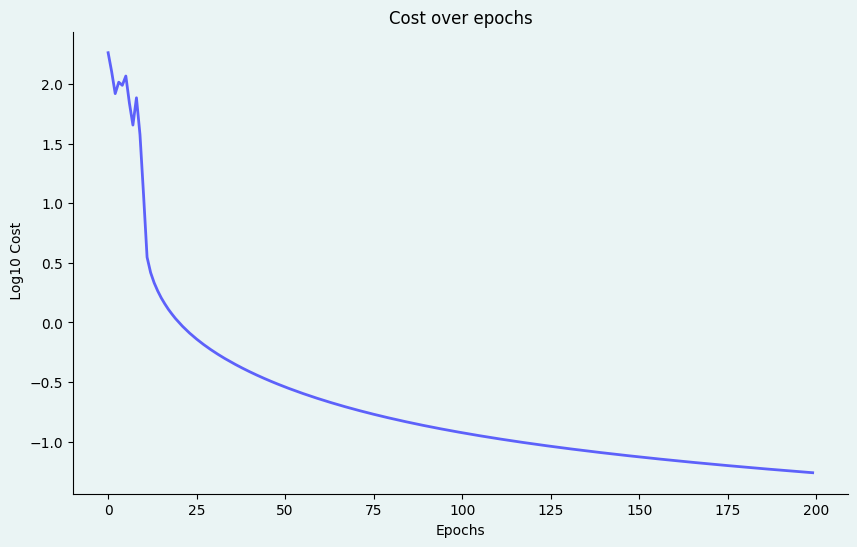

In [62]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(costs, color="blue", label="Cost", alpha=0.6, linewidth=2)
ax.set_title("Cost over epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel(" Log10 Cost")
ax.set_facecolor("#EAF4f4")
fig.set_facecolor("#EAF4f4")
ax.spines[["top", "right"]].set_visible(False)
plt.show()

<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    نمودار تغییرات تابع هزینه در طول زمان<br>
    در اینجا مقدار لگاریتم تابع هزینه را در مبنا 10 نمایش داده‌ایم تا روند تغییرات را بهتر مشاهده کنیم.
</font>    
</p>


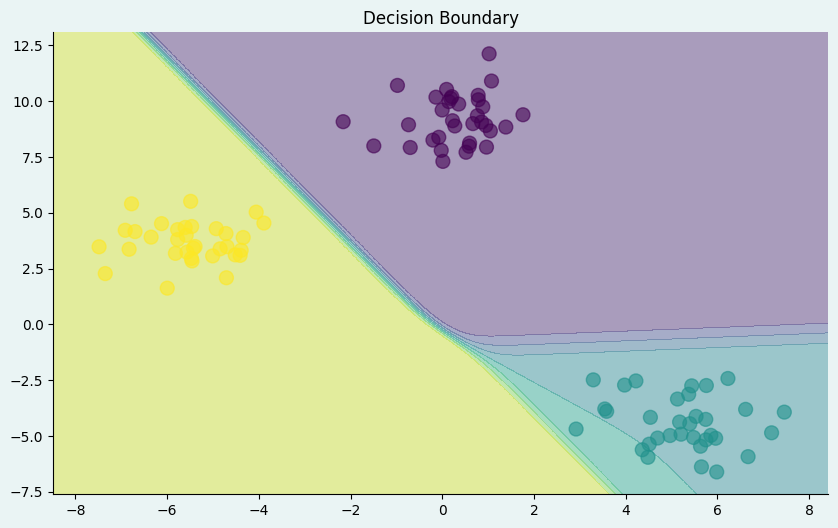

In [63]:
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = np.array([model([x, y]).value for x, y in np.c_[xx.ravel(), yy.ravel()]])
Z = Z.reshape(xx.shape)

ax.contourf(xx, yy, Z, alpha=0.4, cmap="viridis")

ax.scatter(X[:,0], X[:,1], c=Y, cmap="viridis", alpha=0.6, s=100)

ax.set_title("Decision Boundary")
ax.set_facecolor("#EAF4f4")
fig.set_facecolor("#EAF4f4")
ax.spines[["top", "right"]].set_visible(False)
plt.show()


<p dir=rtl style="direction: rtl;text-align: justify;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    نمودار نواحی تصمیم شبکه عصبی<br>
    در نمودار بالا می‌توانیم مشاهده کنیم که شبکه عصبی ما در هر کدام از نقاط صفحه چه خروجی داشته است. از آنجایی که cost بسیار پایین بود توقع داشتیم که شبکه عصبی تعداد زیادی از داده ها را به درستی پیش‌بینی کرده باشد و مشاهده می‌کنیم که به همین صورت است و تنها چند نقطه از نقاط فیروزه‌ای رنگ در ناحیه ای هستند که مقدار خروجی آن کمی با خروجی مورد انتظار متفاوت است. 
</font>    
</p>


<p dir=rtl style="direction: rtl;text-align: center;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
     مجموعه داده دوم:
</font>    
</p>


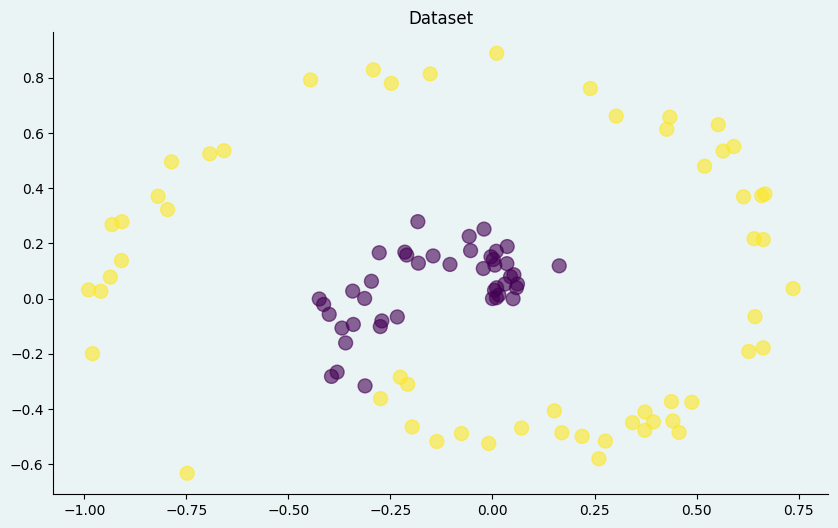

In [94]:
np.random.seed(0)
n = 100
r = np.linspace(0, 1, n)
t = 3 * np.pi * r + np.random.normal(0, 0.5, n)
X = np.c_[r * np.cos(t), r * np.sin(t)]
Y = np.zeros(n)
Y[t > 4] = 1
Y[Y == 0] = -1

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(X[:,0], X[:,1], c=Y, cmap="viridis", alpha=0.6, s=100)

ax.set_title("Dataset")
ax.set_facecolor("#EAF4f4")
fig.set_facecolor("#EAF4f4")
ax.spines[["top", "right"]].set_visible(False)

plt.show()

In [108]:
model = MLP(2, [3, 2, 1])
optim = Optimizer(model.parameters(), 0.005)

n_epochs = 200
costs = []
for epoch in range(n_epochs):
    y_hats = [model(x) for x in X]
    
    losses = [F.calc_loss(y_hat, y) for y_hat, y in zip(y_hats, Y)]
    cost = 0
    
    grads = []
    for param in model.parameters():
        grads.append(0)

    for loss in losses:
        cost += loss.value
        optim.zero_grad()
        F.backward_button(loss)
        i = 0
        for param in model.parameters():
            grads[i] += param.grad
            i += 1

    for grad in grads:
        grad /= len(Y)

    optim.step(grads)
   
    print(f'epoch{epoch+1} : cost:', cost/len(Y))
    costs.append(math.log10(cost))

epoch1 : cost: 1.5067540656646605
epoch2 : cost: 1.203933940006096
epoch3 : cost: 1.0273307207474118
epoch4 : cost: 1.0618947627779076
epoch5 : cost: 1.0475988710659885
epoch6 : cost: 1.0779238355820588
epoch7 : cost: 1.0349318212614582
epoch8 : cost: 1.0511095141356406
epoch9 : cost: 1.0204883225085413
epoch10 : cost: 1.029945942653407
epoch11 : cost: 1.0101443736314217
epoch12 : cost: 1.0157636692042515
epoch13 : cost: 1.0018409353956914
epoch14 : cost: 1.0050047513805596
epoch15 : cost: 0.9937133026494158
epoch16 : cost: 0.9948906046595151
epoch17 : cost: 0.9861654681451978
epoch18 : cost: 0.9864965634499672
epoch19 : cost: 0.979175682744189
epoch20 : cost: 0.9779858971958701
epoch21 : cost: 0.9707851638916061
epoch22 : cost: 0.9688648905112683
epoch23 : cost: 0.963241535444056
epoch24 : cost: 0.9607551860182061
epoch25 : cost: 0.9548660016899997
epoch26 : cost: 0.9533038193063612
epoch27 : cost: 0.9478905978944477
epoch28 : cost: 0.947262108824427
epoch29 : cost: 0.9407238030642402

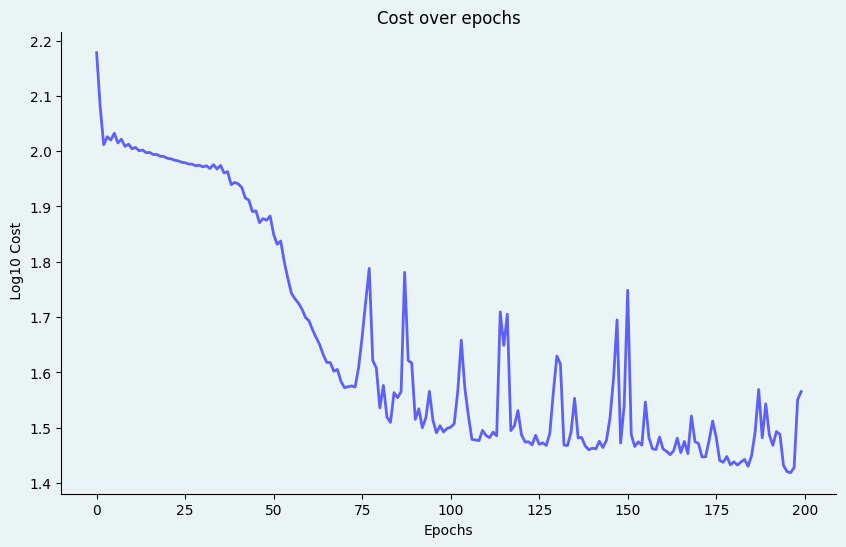

In [109]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(costs, color="blue", label="Cost", alpha=0.6, linewidth=2)
ax.set_title("Cost over epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel(" Log10 Cost")
ax.set_facecolor("#EAF4f4")
fig.set_facecolor("#EAF4f4")
ax.spines[["top", "right"]].set_visible(False)
plt.show()


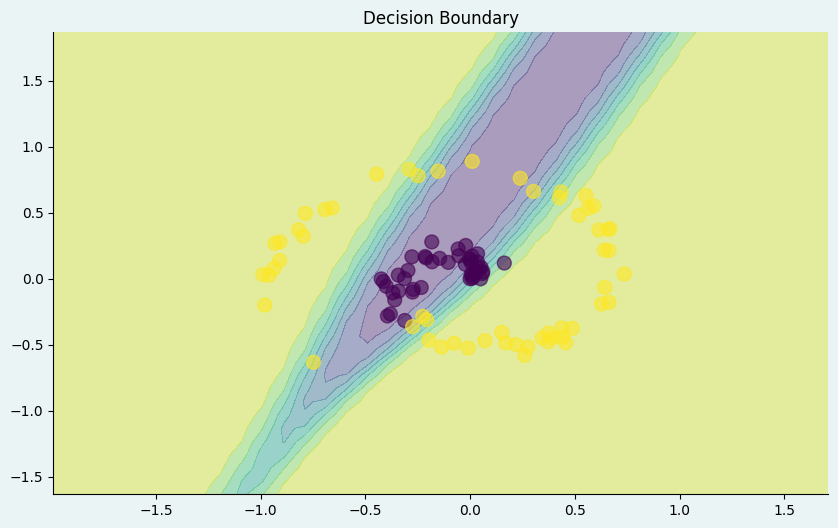

In [110]:
fig, ax = plt.subplots(figsize=(10, 6))

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = np.array([model([x, y]).value for x, y in np.c_[xx.ravel(), yy.ravel()]])
Z = Z.reshape(xx.shape)

ax.contourf(xx, yy, Z, alpha=0.4, cmap="viridis")

ax.scatter(X[:,0], X[:,1], c=Y, cmap="viridis", alpha=0.6, s=100)

ax.set_title("Decision Boundary")
ax.set_facecolor("#EAF4f4")
fig.set_facecolor("#EAF4f4")
ax.spines[["top", "right"]].set_visible(False)
plt.show()


<p dir=rtl style="direction: rtl;text-align: center;line-height:200%;font-family:vazir;font-size:medium">
<font face="vazir" size=3>
    مجموعه داده سوم:
</font>    
</p>


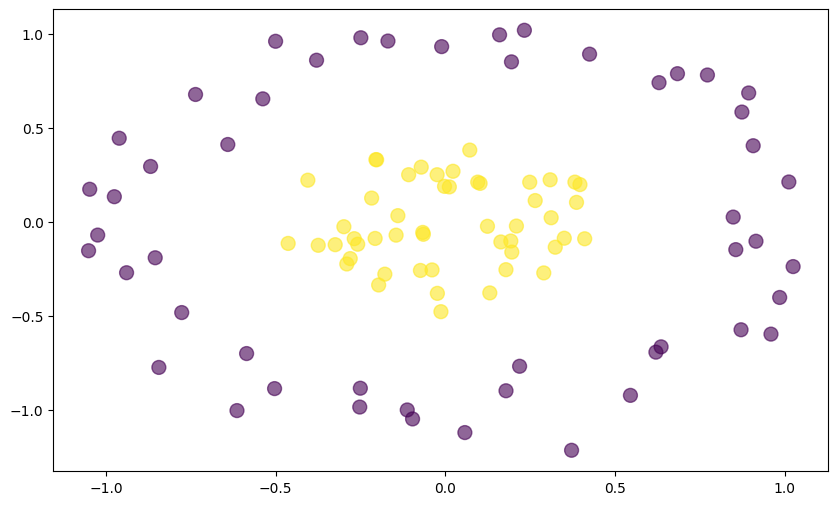

In [140]:
from sklearn.datasets import make_circles

X, Y = make_circles(n_samples=100, factor=.3, noise=.1)
Y[Y == 0] = -1

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(X[:,0], X[:,1], c=Y, cmap="viridis", alpha=0.6, s=100)
plt.show()


In [141]:
model = MLP(2, [4, 2, 1])
optim = Optimizer(model.parameters(), 0.01)

n_epochs = 200
costs = []
for epoch in range(n_epochs):
    y_hats = [model(x) for x in X]
    
    losses = [F.calc_loss(y_hat, y) for y_hat, y in zip(y_hats, Y)]
    cost = 0
    
    grads = []
    for param in model.parameters():
        grads.append(0)

    for loss in losses:
        cost += loss.value
        optim.zero_grad()
        F.backward_button(loss)
        i = 0
        for param in model.parameters():
            grads[i] += param.grad
            i += 1

    for grad in grads:
        grad /= len(Y)

    optim.step(grads)
   
    print(f'epoch{epoch+1} : cost:', cost/len(Y))
    costs.append(math.log10(cost))

epoch1 : cost: 1.6590401999484226
epoch2 : cost: 1.0052623141389323
epoch3 : cost: 1.158224230799992
epoch4 : cost: 1.2015490543865692
epoch5 : cost: 1.0628789558996454
epoch6 : cost: 0.8883008319677979
epoch7 : cost: 0.8972478548530947
epoch8 : cost: 1.0091025118013135
epoch9 : cost: 0.9618807212234186
epoch10 : cost: 1.1120018699563223
epoch11 : cost: 0.8778657222760182
epoch12 : cost: 0.8480152076390287
epoch13 : cost: 0.8912358771170075
epoch14 : cost: 1.0037296171152696
epoch15 : cost: 1.1725971722874433
epoch16 : cost: 1.0178261081735676
epoch17 : cost: 0.8104926535216428
epoch18 : cost: 0.8024129913517963
epoch19 : cost: 0.7878387721632165
epoch20 : cost: 0.7916499078105476
epoch21 : cost: 0.8417195865542014
epoch22 : cost: 0.9531365004323501
epoch23 : cost: 1.1923903460251766
epoch24 : cost: 0.8801515505676036
epoch25 : cost: 0.7478205771854226
epoch26 : cost: 1.030156748311074
epoch27 : cost: 0.6943373422511654
epoch28 : cost: 0.594803838016932
epoch29 : cost: 0.58055381588672

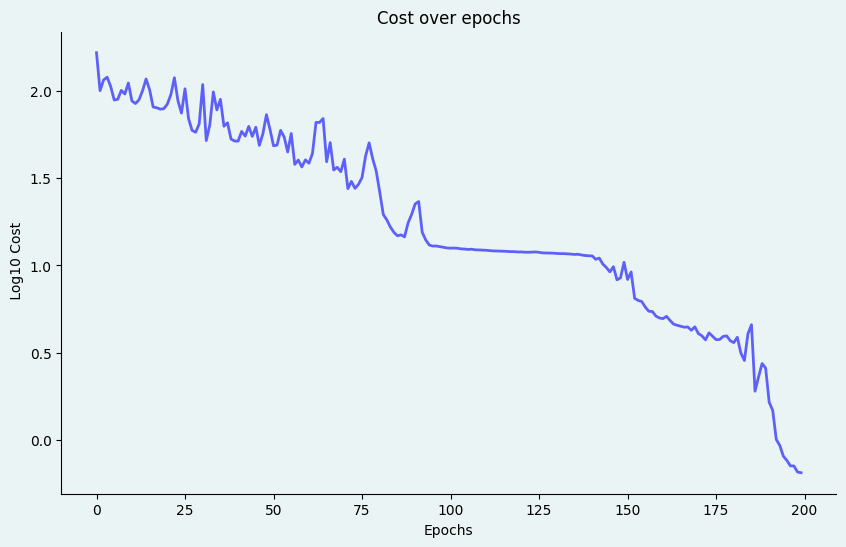

In [142]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(costs, color="blue", label="Cost", alpha=0.6, linewidth=2)
ax.set_title("Cost over epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel(" Log10 Cost")
ax.set_facecolor("#EAF4f4")
fig.set_facecolor("#EAF4f4")
ax.spines[["top", "right"]].set_visible(False)
plt.show()

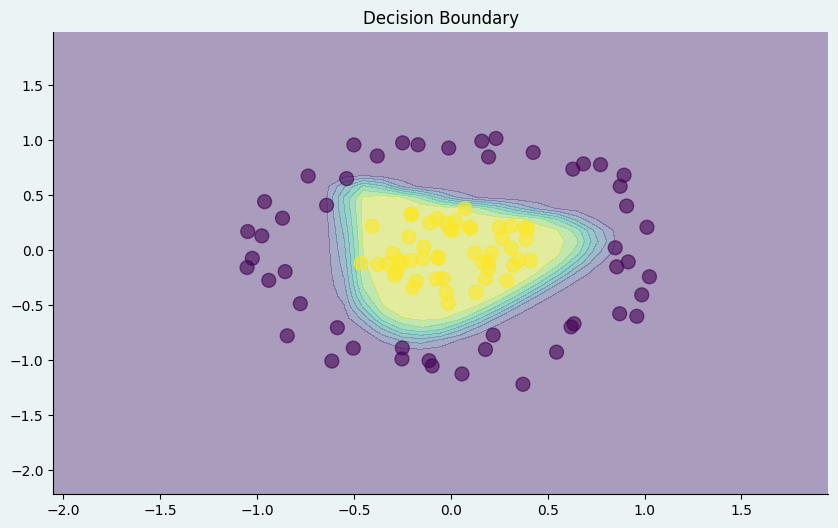

In [143]:
fig, ax = plt.subplots(figsize=(10, 6))

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

Z = np.array([model([x, y]).value for x, y in np.c_[xx.ravel(), yy.ravel()]])
Z = Z.reshape(xx.shape)

ax.contourf(xx, yy, Z, alpha=0.4, cmap="viridis")

ax.scatter(X[:,0], X[:,1], c=Y, cmap="viridis", alpha=0.6, s=100)

ax.set_title("Decision Boundary")
ax.set_facecolor("#EAF4f4")
fig.set_facecolor("#EAF4f4")
ax.spines[["top", "right"]].set_visible(False)
plt.show()